In [1]:
import os
import samplers
import samplers_biased
import numpy as np
import matplotlib.pyplot as plt


### run parallel chains on a CPU, adjusted to local system.
n_chains = 10
os.environ['XLA_FLAGS'] = (
    f'--xla_force_host_platform_device_count={n_chains} '
)
import jax.numpy as jnp
import jax

### specify the target
### p(x,z)=p(z)*p(x|z) with 
### p(z) Gaussian mixture, p(x|z) Gaussian with mean mux(z) and std sigmax(z)
dimx = 19 # dimension of x
d = 10. # distance between the two modes
w1 = 0.3 # relative weight of the first mode
sigmax_vals = np.linspace(0.5, 5, dimx) # width of p(xx|z) for each component of x

### Parameters of the sampler
choice_sampler = "SymMala"
z0 = 0. # initial z-value (of the CV)
x0val = 5. # initial value of x^\perp
dt = 0.4
velocity = 6.5E-3

n_steps = 5000

# proposal in z is almost the target p(z) but with incorrect weights for the modes
w1_proposal = 0.5

x0 = jnp.array(dimx*[x0val,])

def marginalpz(z):
    return 1/jnp.sqrt(2*jnp.pi) * (
        w1 * jnp.exp(-0.5 * z**2) 
        + (1-w1) * jnp.exp(-0.5 * (z-d)**2))

def sigmax(z):
    return sigmax_vals

def mux(z):
    return jnp.cos(z/d*np.pi) * d/2

def probfull_cond(z, x):
    """p(x|z)"""
    return 1/((2 * jnp.pi)**(dimx/2) * jnp.prod(sigmax(z))) * jnp.exp(-0.5*jnp.sum(((x-mux(z))/sigmax(z))**2))

@jax.jit
def probfull(z, x):
    return marginalpz(z) * probfull_cond(z, x)

@jax.jit
def energy(z, x):
    return -jnp.log(probfull(z, x))

@jax.jit
def energy_partialx(z, x):
    ### ∂_x -log(p) = -(∂_x p) * 1/p 
    return 1/sigmax(z)**2 * (x - mux(z))


@jax.jit
def z_sampler_custom(z,key):
    subkeys = jax.random.split(key,4)
    key = subkeys[0]
    subkeys = subkeys[1:]
    coin = jax.random.uniform(subkeys[0]) <= w1_proposal
    mode1 = jax.random.normal(subkeys[1])
    mode2 = jax.random.normal(subkeys[2]) + d
    result = jnp.where(coin, mode1, mode2)
    return result, key

@jax.jit
def z_sampler_log_prob(z, zold):
    prob = 1/jnp.sqrt(2*jnp.pi) * (w1_proposal * jnp.exp(-0.5 * z**2) 
                                   + (1-w1_proposal) * jnp.exp(-0.5 * (z-d)**2))
    return jnp.log(prob)

key = jax.random.PRNGKey(42)

if choice_sampler == "Asym":
    sampler = samplers.AsymSampler(energy, energy_partialx, z_sampler_custom, z_sampler_log_prob)
elif choice_sampler == "SymMala":
    sampler = samplers.SymMalaSampler(energy, energy_partialx, z_sampler_custom, z_sampler_log_prob)
elif choice_sampler == "SymUla":
    sampler = samplers.SymUlaSampler(energy, energy_partialx, z_sampler_custom, z_sampler_log_prob)
elif choice_sampler == "CoinMala":
    sampler = samplers.CoinMalaSampler(energy, energy_partialx, z_sampler_custom, z_sampler_log_prob)
elif choice_sampler == "CoinUla":
    sampler = samplers.CoinUlaSampler(energy, energy_partialx, z_sampler_custom, z_sampler_log_prob)
elif choice_sampler == "SymUlaBiased":
    sampler = samplers_biased.SymUlaBiasedSampler(energy, energy_partialx, z_sampler_custom, z_sampler_log_prob)
elif choice_sampler == "NoCoinflipUlaBiased":
    sampler = samplers_biased.NoCoinflipUlaBiasedSampler(energy, energy_partialx, z_sampler_custom, z_sampler_log_prob)
elif choice_sampler == "NoCoinflipMalaBiased":
    sampler = samplers_biased.NoCoinflipMalaBiasedSampler(energy, energy_partialx, z_sampler_custom, z_sampler_log_prob)    
else:
    raise NotImplementedError("Unrecognized sampler")           

def get_samples_custom(x0,z0,velocity,dt,key): 
    global n_steps
    return sampler.get_samples(x0,z0,velocity,dt,n_steps, key)

In [2]:
get_samples_custom_parallel = jax.pmap(get_samples_custom, in_axes=(None,None,None,None,0))

keys = jax.random.split(key,num=n_chains+1)
key = keys[0]
subkeys = keys[1:]

z_traj_list, x_traj_list, pacc_list,n_inter_traj_list,key_list = get_samples_custom_parallel(x0,z0,velocity,dt,subkeys)


Text(0, 0.5, '$p(z)$')

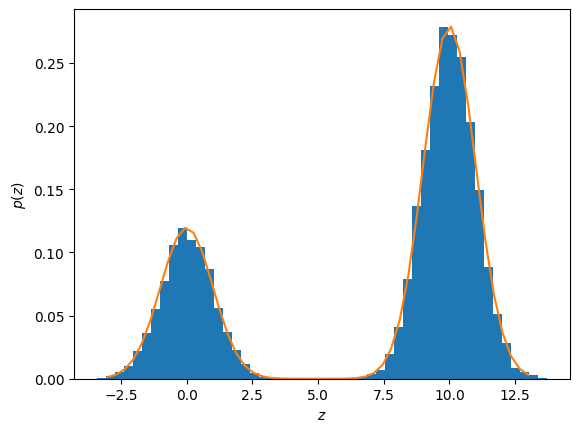

In [3]:
plt.hist(np.array(z_traj_list).flatten(), bins = 50, density=True);
z_values = np.linspace(-3,13)
plt.plot(z_values, marginalpz(z_values))
plt.xlabel("$z$")
plt.ylabel("$p(z)$")